In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'indian-languages-audio-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3948432%2F6871056%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240709%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240709T123503Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D15058630695d262ea1e05c2cda3392fd125d49be9e4e12ed62ad3c60f26f5048fceab60e3b17900e6f2854edf3ee80d864e8c6cc6a1fe46dbaa4e040ec19c447c910cbc5ca192b3c5ac7c0da90c602b3b5a59d77a9a1f6b58f1c474a7865acc3003f73626afcd2775081b1b30230d25ae6ed3987bce1edc7e22130f5740bd23d6b338fef45ebccc19fc346791551a9e21ec5884a8b34620f73b590cbcea110a8b70fda09f44c6600d4e32488c245a5319333e9448bb25450ba63ffbc9f75e51b04d68eca40dcaa6964ccfa71999f9e7459d49085a93570c255401d4d2a4b68f5da786dd7998e98adb6ab8d934b428c68721f2c7bd5b3aa993de6bab73182e9e4'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 747799431 bytes downloaded
Downloaded and uncompressed: indian-languages-audio-dataset
Data source import complete.


In [2]:
import os
import numpy as np
import pandas as pd
import librosa
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [3]:
# Define base directory
base_dir = '/kaggle/input/indian-languages-audio-dataset/Indian_Languages_Audio_Dataset/'

In [4]:
from pathlib import Path
import random
from IPython.display import Audio, display

for path in Path(base_dir).iterdir():
    if path.is_dir():
      print(f"{path.name}: {len(list(path.glob('*')))}")
languages = os.listdir(base_dir)
for language in languages:
    language_dir = os.path.join(base_dir, language)
    audio_files = glob(os.path.join(language_dir, '*.mp3'))
    random_audio_file = random.choice(audio_files)
    print(language)
    display(Audio(random_audio_file))

Malayalam: 1000
Bengali: 1000
Kannada: 1000
Hindi: 1000
Punjabi: 1000
Marathi: 1000
Gujarati: 1000
Urdu: 1000
Tamil: 1000
Telugu: 1000
Malayalam


Bengali


Kannada


Hindi


Punjabi


Marathi


Gujarati


Urdu


Tamil


Telugu


In [5]:
# Function to extract features
def feature_extract(languages):
    features = []
    labels = []

    for language in languages:
        language_dir = os.path.join(base_dir, language)
        audio_files = glob(os.path.join(language_dir, '*.mp3'))

        for audio_file in audio_files:
            try:
                audio, sample_rate = librosa.load(audio_file)
                mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
                mfccs_mean = np.mean(mfccs, axis=1)
                features.append(mfccs_mean)
                labels.append(language)
            except Exception as e:
                print(f"Error processing {audio_file}: {e}")

    return np.array(features), np.array(labels)

In [6]:

# Get list of languages
languages = os.listdir(base_dir)

# Extract features and labels
X, y = feature_extract(languages)

# Encode labels
lb = LabelEncoder()
y = lb.fit_transform(y)

In [7]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
# Initialize KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)

# Train KNN model
knn_classifier.fit(X_train, y_train)

# Predict on test data
y_pred = knn_classifier.predict(X_test)

In [9]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.844


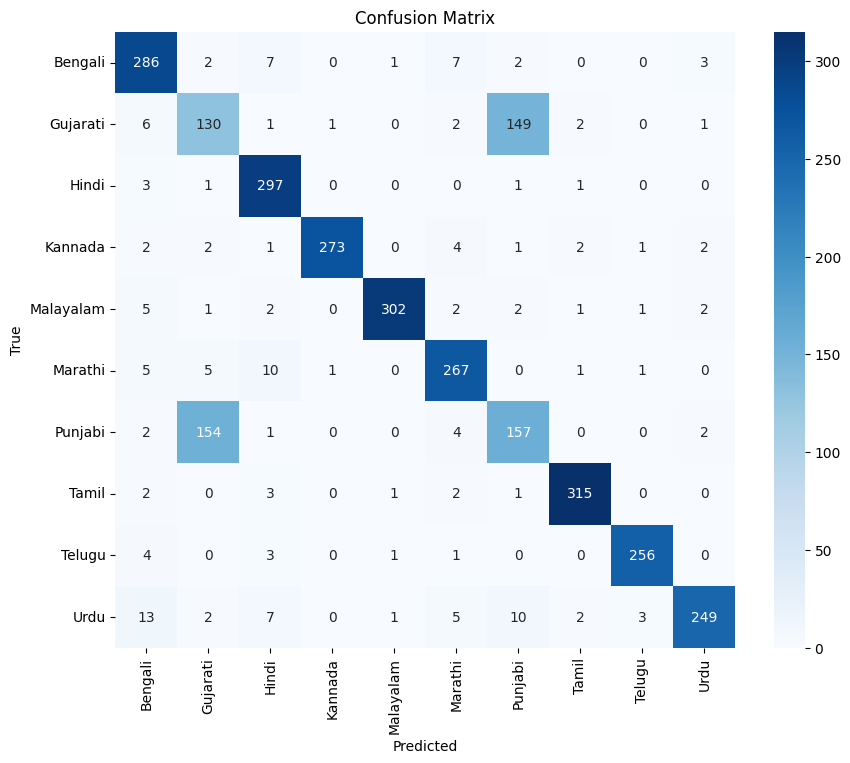

In [10]:
# Confusion Matrix
confusion_mtx = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=lb.classes_, yticklabels=lb.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()